In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [84]:
import pandas as pd
import numpy as np

In [3]:
def create_subset(m, years, samples_per_day = 24, days_per_year = 365):
    """
    Actual subset of data from a span of n years
    """
    r = np.random.randint(0,m.shape[0]-(years * (days_per_year*samples_per_day)))
    subset = m[r:r+(years*(days_per_year*samples_per_day))]
    return subset

In [4]:
def find_signature(subset, years, var, samples_per_day = 24, days_per_year = 365):
    """
    Takes weather observations over time
    Returns a frequency spectrum in the range 0 - 366 Hz
    """
    freqs = np.fft.fftfreq((years*(days_per_year*samples_per_day)), 1/(days_per_year*samples_per_day))
    
    fft = np.fft.fft(subset[var])
    fft_filtered = fft.copy()
    
    # we lose a bit of information like this, mainly smoothing over outliers
    high_non_integer_frequencies = (np.abs(freqs) > days_per_year + 1) | (np.abs(freqs) % 1 != 0)
    fft_filtered[high_non_integer_frequencies] = 0
    
    # okay to filter these because the information is symmetric
    # take the negative frequency with the complex conjugate to reconstruct the original signal
    unnatural_frequencies = high_non_integer_frequencies | (freqs < 0)
    signature = pd.Series(fft_filtered[~unnatural_frequencies], index = freqs[~unnatural_frequencies])

    return signature

In [83]:
def bootstrap_signatures(m, samples, years, var_list):
    """
    Resample over time periods in the data, turning years of temperature data into 367 component frequencies
    """
    collect = list()
    for s in range(samples):
        subset = create_subset(m, years)
        
        signature_groups = list()
        for var in var_list:
            signature = find_signature(subset, years, var=var)
            real_part = pd.Series(np.real(signature))
            real_part.index = pd.Index([f'{var}_{int(ind)}_real' for ind in real_part.index])
            imag_part = pd.Series(np.imag(signature))
            imag_part.index = pd.Index([f'{var}_{int(ind)}_imag' for ind in imag_part.index])
            sig = pd.concat([real_part, imag_part])
            signature_groups.append(sig)
        
        bs = pd.concat(signature_groups)
        bs['start_date'] = subset.date.min()
        bs['end_date'] = subset.date.max()
        collect.append(bs)

    yay = pd.concat(collect,axis=1).T
    yay.end_date = yay.end_date.astype('datetime64')
    yay.start_date = yay.start_date.astype('datetime64')
    return yay

In [68]:
def decode(sample_point, components, days_per_year=365 ,samples_per_day=24, years=3):

    unembedded = pd.DataFrame(np.dot(sample_point, components), index=b.columns).T

    real_part = np.array(unembedded[[c for c in unembedded.columns if c.endswith('real')]])
    imag_part = np.array(1j * unembedded[[c for c in unembedded.columns if c.endswith('imag')]])

    signature = pd.Series((real_part + imag_part)[0], index=pd.RangeIndex(days_per_year+2))
    reverse_conjugate = signature.apply(np.conjugate)[::-1]
    reverse_conjugate.index = -reverse_conjugate.index
    reverse_conjugate = pd.Series(reverse_conjugate[abs(reverse_conjugate.index.values) > 0])
    
    reconstruction_length = days_per_year*samples_per_day
    imaginary = np.concatenate((
        np.array(signature),
        np.zeros(reconstruction_length - ((2*signature.shape[0])-1)),
        np.array(reverse_conjugate)
    ))
    recons = np.real(np.fft.ifft(imaginary)) / years

    return recons

In [6]:
def get_boostrap_samples(df, bootstrap_samples=20, year_window=1, var_list=['tmp']):
    
    signatures = df.groupby('station').apply(
        bootstrap_signatures,
        samples=bootstrap_samples, years=year_window,
        var_list=var_list
    )
    
    signatures.reset_index(inplace=True)
    sample_periods = signatures[['station','start_date','end_date']]
    signatures.drop(['level_1'], axis=1, inplace=True)
    
    return signatures, sample_periods

In [80]:
def SVD_coordinates(b):
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD()
    rdc = svd.fit_transform(b)
    return rdc[:,0], rdc[:,1], svd.components_, svd.explained_variance_ratio_

In [7]:
PATH = f'/home/ubuntu/climate-classification/data'

In [8]:
df = pd.read_feather(f'{PATH}/df')
metadata = pd.read_feather(f'{PATH}/metadata')

In [87]:
# LA and another one are inaccurate :(
df = df[df.station != '72295699999']
df = df[df.station != '36982099999']
df.station = df.station.astype('str').astype('category')

metadata = metadata[metadata.station != '72295699999']
metadata = metadata[metadata.station != '36982099999']
metadata.station = metadata.station.astype('str').astype('category')

In [86]:
final, sample_periods = get_boostrap_samples(
    df,
    bootstrap_samples=20, year_window=3,
    var_list = ['tmp']
)

In [12]:
# merge in stats about each city
stats = df.groupby('station')[['tmp']].mean()
stats.reset_index(inplace=True)
more = pd.merge(metadata, stats)

In [ ]:
b = final.drop(['station','start_date','end_date'], axis='columns')
coord = final[['station','start_date','end_date']].copy()

In [81]:
coord['x1'], coord['x2'], components, explained_variance = SVD_coordinates(b)

In [88]:
explained_variance

array([0.68257289, 0.13237604])

In [96]:
# actual temperatures
this_period = df[(df.date >= coord['start_date'].loc[i]) & (df.date <= coord['end_date'].loc[i]) & (df.station==coord.station[0])]
print(this_period.tmp.mean()); print(this_period.tmp.std())


5.998097
8.7588


In [97]:
# unembedded temps
estimated = decode(sample_point=sample_point, components=components)
print(estimated.mean()); print(estimated.std())

5.6149772999726935
6.0698052887012155


In [74]:
coordinates = coord[['station','x1','x2']].groupby('station').median()
coordinates.reset_index(drop=False, inplace=True)
more2 = pd.merge(more, coordinates)

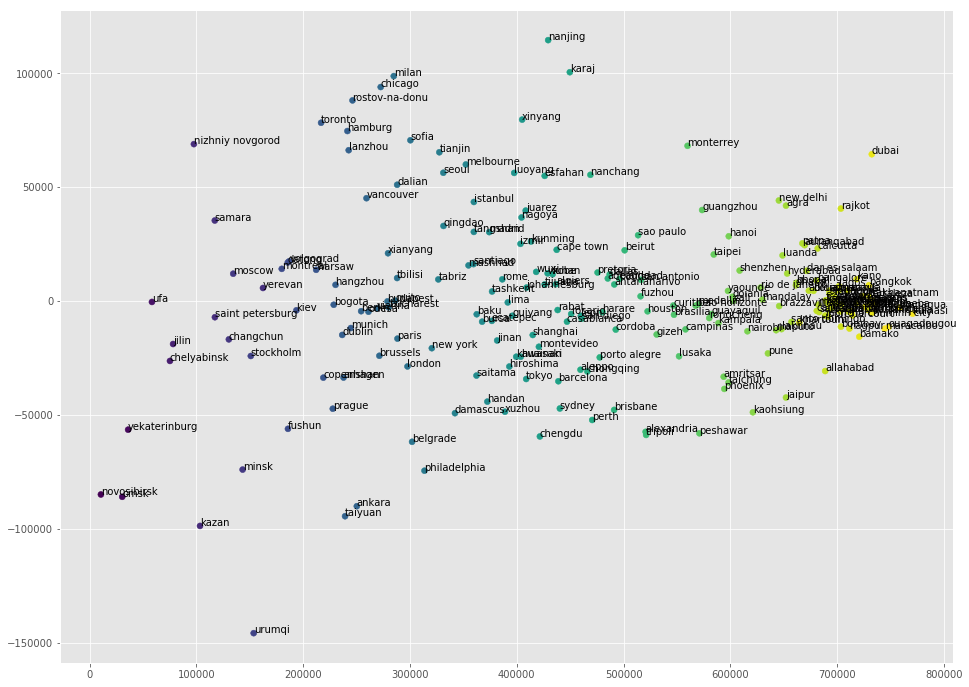

In [76]:
fig, ax = plt.subplots(figsize=(16, 12))
plt.scatter(more2.x1, more2.x2, c=more2.tmp)
for i, txt in enumerate(metadata.City):
    ax.annotate(txt, (more2.x1[i], more2.x2[i]))